## Import Library

- tensorflow 2.x(tf.keras)
- pandas
- numpy
- datetime
- matplotlib.pyplot
- google.colab
- os

In [1]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

import os

print(tf.__version__)

2.3.0


## Google Colab Mount

- account : leeyeoreum01@gmail.com

In [2]:
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## Google Colab Working Directory Select

- csv file dir = 'tensorflow_2.x_working_dir'
- ipynb file dir = 'Colab Notebooks'

In [3]:
working_dir = 'digit_recognizer_data'

colab_default_dir = '/content/gdrive/My Drive/Colab Notebooks/my_own_program/AI program/data'

original_dir = os.getcwd()

try:

    os.chdir(colab_default_dir)

    if not os.path.exists(working_dir):
        os.mkdir(working_dir)

    os.chdir(working_dir)

    print('current_dir = ', os.getcwd())

except Exception as err:

    os.chdir(original_dir)
    print(str(err))

current_dir =  /content/gdrive/My Drive/Colab Notebooks/my_own_program/AI program/data/digit_recognizer_data


## CSV File Data Upload

- digit_train.csv
- digit_test.csv

In [ ]:
try:

    original_train_df = pd.read_csv('digit_train.csv')
    #original_train_df = pd.read_csv('digit_train_v2.csv') 
    original_test_df = pd.read_csv('digit_test.csv')

    print('type(original_train_df) = ', type(original_train_df))
    print('original_train_df.shape = ', original_train_df.shape)
    print()
    print('type(original_test_df) = ', type(original_test_df))
    print('original_test_df.shape = ', original_test_df.shape)

    train_df = original_train_df.copy()
    test_df = original_test_df.copy()
    
except Exception as err:
    
    print(str(err))

type(original_train_df) =  <class 'pandas.core.frame.DataFrame'>
original_train_df.shape =  (42000, 785)

type(original_test_df) =  <class 'pandas.core.frame.DataFrame'>
original_test_df.shape =  (28000, 784)


## Data Generation

- train data : 70%
- test data : 30%

- Normalization (+ test data (<- test df)): True

In [ ]:
class DataGeneration:
    
    # target_position = 0 (첫번째열이 정답데이터), target_position=-1 (마지막열이 정답데이터)
    def __init__(self, file, seperation_rate, target_position=-1):
        
        self.file = file
        
        self.seperation_rate = seperation_rate
        
        if (target_position == -1  or  target_position == 0):      
            self.target_position = target_position
        
        else:
            err_str = 'target_position must be -1 or 0'            
            raise Exception(err_str)    
            
    
    # print data target distribution 
    # str_of_kind : 'original data' or  'training data'  or  'test data'
    def __display_target_distribution(self, data, str_of_kind='original data'):
        
        print('=======================================================================================================')
        
        target_data = data[ :, self.target_position ]
        
        # numpy.unique() 사용하여 loaded data target 분포 확인
        unique, counts = np.unique(target_data, return_counts=True)

        unique_target = []
    
        for index in range(len(unique)):
        
            print('[DataGeneration] unique number of ' + str_of_kind + ' = ', unique[index], 
                  ', count = ', counts[index], ', ratio = ', np.round(100 * counts[index] / (target_data.shape[0]), 2), ' %')
        
            unique_target.append(unique[index])
    
        print('=======================================================================================================')
        
        
    # numpy.random.shuffle()  이용하여 training_data / test_data 생성
    def generate(self):
    
        # 데이터 불러오기, 파일이 없는 경우 exception 발생

        loaded_data = self.file

        print("[DataGeneration]  loaded_data.shape = ", loaded_data.shape)
            
        # print the target distribution of original data 
        
        self.__display_target_distribution(loaded_data, 'original data')
        
        
        # 분리비율에 맞게 테스트데이터로 분리
        total_data_num = len(loaded_data)
        test_data_num = int(len(loaded_data) * self.seperation_rate)

        # numpy.random.shuffle 을 이용하여 랜덤하게 데이터 섞기
        np.random.shuffle(loaded_data)
        
        # test_data 는 0 : test_data_num
        
        
        test_data = loaded_data[ 0:test_data_num ]

        # training_data 는 test_data_num 부터 끝까지 
        training_data = loaded_data[ test_data_num: ]

        # display target distribution of generated data 
        
        self.__display_target_distribution(training_data, 'training data')
        
        self.__display_target_distribution(test_data, 'test data')
        
        return training_data, test_data

In [ ]:
# DataGeneration class 이용하여 training data , validation data, test data 생성

train_data = np.array(train_df) # 학습 데이터프레임

data_obj = DataGeneration(train_data, seperation_rate=0.3, target_position=0)
(train_train_data, train_test_data) = data_obj.generate()

test_data = np.array(test_df) # 예측 데이터프레임

print("train_data.shape = ", train_data.shape,
      ", train_data.ndim = ", train_data.ndim)
print("train_train_data.shape = ", train_train_data.shape, 
      ", train_test_data.shape = ", train_test_data.shape)
print("test_data.shape = ", test_data.shape,
      ", test_data.ndim = ", test_data.ndim)

[DataGeneration]  loaded_data.shape =  (42000, 785)
[DataGeneration] unique number of original data =  0 , count =  4132 , ratio =  9.84  %
[DataGeneration] unique number of original data =  1 , count =  4684 , ratio =  11.15  %
[DataGeneration] unique number of original data =  2 , count =  4177 , ratio =  9.95  %
[DataGeneration] unique number of original data =  3 , count =  4351 , ratio =  10.36  %
[DataGeneration] unique number of original data =  4 , count =  4072 , ratio =  9.7  %
[DataGeneration] unique number of original data =  5 , count =  3795 , ratio =  9.04  %
[DataGeneration] unique number of original data =  6 , count =  4137 , ratio =  9.85  %
[DataGeneration] unique number of original data =  7 , count =  4401 , ratio =  10.48  %
[DataGeneration] unique number of original data =  8 , count =  4063 , ratio =  9.67  %
[DataGeneration] unique number of original data =  9 , count =  4188 , ratio =  9.97  %
[DataGeneration] unique number of training data =  0 , count =  29

In [ ]:
train_train_xdata = train_train_data[ :  , 1:]
train_train_tdata = train_train_data[ :  , [0]]

train_test_xdata = train_test_data[ :  , 1:]
train_test_tdata = train_test_data[ :  , [0]]

print("train_train_xdata = ", train_train_xdata.shape, 
      ", train_train_tdata = ", train_train_tdata.shape)
print("train_test_xdata = ", train_test_xdata.shape, 
      ", train_test_tdata = ", train_test_tdata.shape)

train_train_xdata =  (29400, 784) , train_train_tdata =  (29400, 1)
train_test_xdata =  (12600, 784) , train_test_tdata =  (12600, 1)


In [ ]:
# 정규화(Normalization) 코드

def data_normalization(data):
  
    try:

        if data.ndim != 2:
            raise Exception("Warning: input data must be 2 dim!!")

        data = (data - np.min(data)) / (np.max(data) - np.min(data))

        return data

    except Exception as err:
        raise Exception

try:
    train_train_xdata = data_normalization(train_train_xdata)
    train_test_xdata = data_normalization(train_test_xdata)
    test_data = data_normalization(test_data)

except Exception as err:
    print(str(err))


In [ ]:
print('max(train_train_xdata) = ', np.max(train_train_xdata))
print('min(train_train_xdata) = ', np.min(train_train_xdata))
print()

print('max(train_test_xdata) = ', np.max(train_test_xdata))
print('min(train_test_xdata) = ', np.min(train_test_xdata))
print()

print('max(test_data) = ', np.max(test_data))
print('min(test_data) = ', np.min(test_data))

max(train_train_xdata) =  1.0
min(train_train_xdata) =  0.0

max(train_test_xdata) =  1.0
min(train_test_xdata) =  0.0

max(test_data) =  1.0
min(test_data) =  0.0


## Get Dataframe

- function of getting dataframe before encoding csv

In [ ]:
def get_dataframe(result):

    if result.ndim != 1:
        result = result.reshape(-1) # changing data shape to 1 dim in order to get df

    df = pd.DataFrame({
        'ImageId': np.array(range(1, (len(result)+1))),
        'Label': result
        })

    return df

## Beta Model

In [ ]:
model = Sequential()

model.add(Conv2D(input_shape=(28, 28, 1),
                 kernel_size=5, filters=32,
                 strides=(1, 1), activation='relu', use_bias=True, padding='SAME'))

model.add(Conv2D(input_shape=(28, 28, 1),
                 kernel_size=5, filters=64,
                 strides=(1, 1), activation='relu', use_bias=True, padding='SAME'))

model.add(Conv2D(input_shape=(28, 28, 1),
                 kernel_size=5, filters=64,
                 strides=(1, 1), activation='relu', use_bias=True, padding='SAME'))

model.add(MaxPool2D(pool_size=(2, 2), padding='SAME'))

model.add(Conv2D(input_shape=(28, 28, 1),
                 kernel_size=5, filters=128,
                 strides=(1, 1), activation='relu', use_bias=True, padding='SAME'))

model.add(Conv2D(input_shape=(28, 28, 1),
                 kernel_size=5, filters=256,
                 strides=(1, 1), activation='relu', use_bias=True, padding='SAME'))

model.add(Conv2D(input_shape=(28, 28, 1),
                 kernel_size=5, filters=256,
                 strides=(1, 1), activation='relu', use_bias=True, padding='SAME'))

model.add(MaxPool2D(pool_size=(2, 2), padding='SAME'))

model.add(Flatten())

model.add(Dense(10, activation='softmax'))

In [ ]:
model.compile(optimizer=Adam(lr=1e-4),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 28, 28, 64)        51264     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 28, 28, 64)        102464    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 14, 14, 128)       204928    
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 14, 14, 256)       819456    
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 14, 14, 256)      

In [ ]:
start_time = datetime.now()

hist = model.fit(train_train_xdata.reshape(-1, 28, 28, 1), train_train_tdata,
                 batch_size=50, epochs=50, validation_split=0.1)

end_time = datetime.now()

print('\nElasped time : ', end_time - start_time)

Epoch 1/50
530/530 [==============================] - 30s 57ms/step - loss: 0.2790 - accuracy: 0.9129 - val_loss: 0.1102 - val_accuracy: 0.9639
Epoch 2/50
530/530 [==============================] - 30s 57ms/step - loss: 0.0665 - accuracy: 0.9794 - val_loss: 0.0674 - val_accuracy: 0.9786
Epoch 3/50
530/530 [==============================] - 30s 57ms/step - loss: 0.0464 - accuracy: 0.9850 - val_loss: 0.0493 - val_accuracy: 0.9840
Epoch 4/50
530/530 [==============================] - 30s 56ms/step - loss: 0.0338 - accuracy: 0.9894 - val_loss: 0.0466 - val_accuracy: 0.9857
Epoch 5/50
530/530 [==============================] - 30s 57ms/step - loss: 0.0251 - accuracy: 0.9922 - val_loss: 0.0449 - val_accuracy: 0.9874
Epoch 6/50
530/530 [==============================] - 30s 56ms/step - loss: 0.0178 - accuracy: 0.9949 - val_loss: 0.0668 - val_accuracy: 0.9823
Epoch 7/50
530/530 [==============================] - 30s 56ms/step - loss: 0.0159 - accuracy: 0.9953 - val_loss: 0.0424 - val_accuracy:

KeyboardInterrupt: ignored

In [ ]:
model.evaluate(train_test_xdata.reshape(-1, 28, 28, 1), train_test_tdata)

In [ ]:
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='validation loss')

plt.legend(loc='best')

plt.show()

In [ ]:
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()

plt.plot(hist.history['accuracy'], label='train accuracy')
plt.plot(hist.history['val_accuracy'], label='validation accuracy')

plt.legend(loc='best')

plt.show()

## Processing Contaminated Data

- extracting contaminated data from train_train_xdata
- deleting extracted contaminated data in original_xdata
- debuging deleted data

In [ ]:
real_predict_list = model.predict(train_train_xdata.reshape(-1, 28, 28, 1))

print('type(real_predict_list) = ', type(real_predict_list))
print()

logical_predict_list = np.argmax(real_predict_list, axis=1)

print("logical_predict_list sample = ", logical_predict_list[:10])
print()

label_list = train_train_tdata.flatten()

index_label_prediction_list = [[idx, label_list[idx], prediction] for idx, prediction in enumerate(logical_predict_list) if label_list[idx] != prediction]

print(index_label_prediction_list)

train_accuracy = 1 - (len(index_label_prediction_list) / len(label_list))

print('\ntrain accuracy = ', train_accuracy)

type(real_predict_list) =  <class 'numpy.ndarray'>

logical_predict_list sample =  [6 3 9 9 9 2 2 5 3 7]

[[26453, 4, 9], [26698, 1, 7], [26723, 9, 5], [26724, 9, 8], [26970, 6, 5], [27120, 1, 2], [27135, 9, 4], [27204, 4, 9], [27276, 5, 3], [27680, 3, 8], [27747, 8, 4], [28184, 6, 3], [28478, 7, 2], [28659, 5, 6]]

train accuracy =  0.9995224450811844


len(index_label_prediction_list) =  14



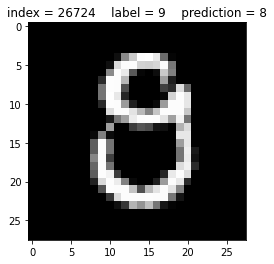

In [ ]:
len_error_data = len(index_label_prediction_list)

print("len(index_label_prediction_list) = ", len_error_data)
print()

random_pick_index = np.random.randint(len_error_data)

false_data_index = index_label_prediction_list[random_pick_index][0]
false_data_label = index_label_prediction_list[random_pick_index][1]
false_data_prediction = index_label_prediction_list[random_pick_index][2]

img = train_train_xdata[false_data_index].reshape(28, 28)

title = 'index = ' + str(false_data_index) + '    ' + 'label = ' + str(false_data_label) + '    ' + 'prediction = ' + str(false_data_prediction)

plt.title(title)
plt.imshow(img, cmap='gray')
plt.show()

len(index_label_prediction_list) =  14

start index : 0
count : 14


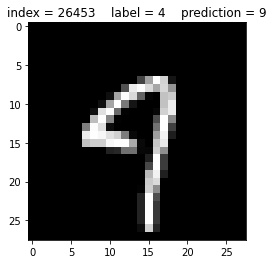

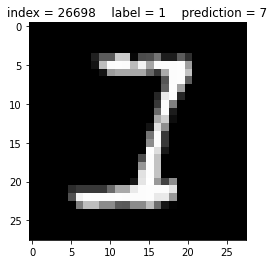

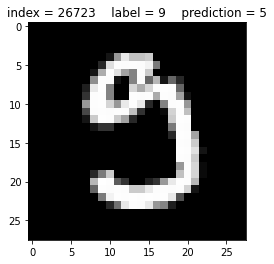

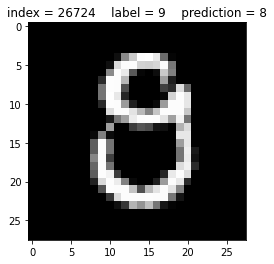

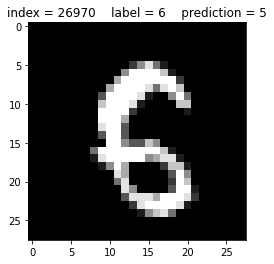

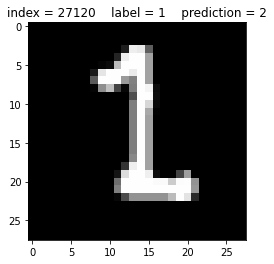

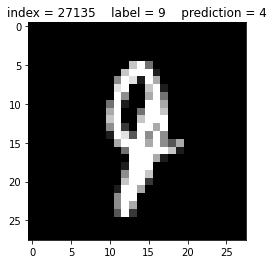

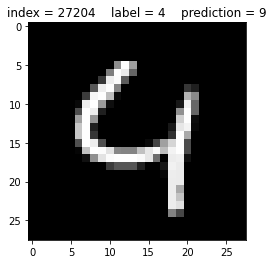

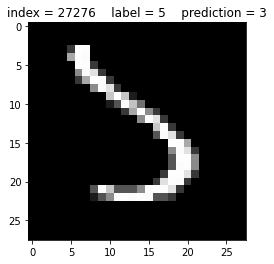

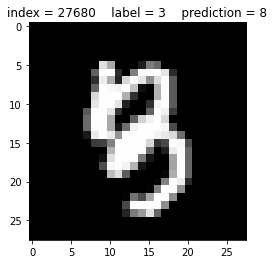

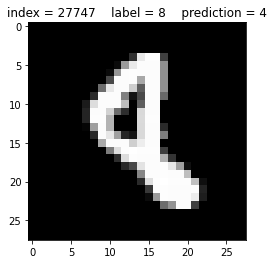

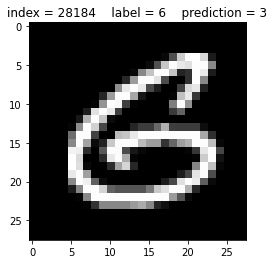

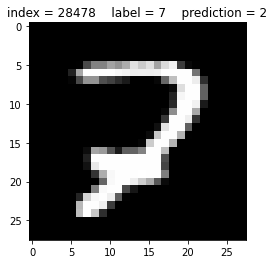

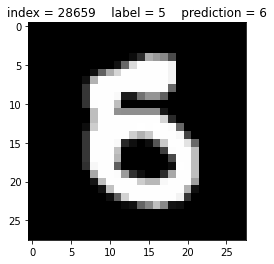

In [ ]:
print("len(index_label_prediction_list) = ", len_error_data)
print()

for self_pick_index in range(len_error_data):

    false_data_index = index_label_prediction_list[self_pick_index][0]
    false_data_label = index_label_prediction_list[self_pick_index][1]
    false_data_prediction = index_label_prediction_list[self_pick_index][2]

    img = train_train_xdata[false_data_index].reshape(28, 28)

    title = 'index = ' + str(false_data_index) + '    ' + 'label = ' + str(false_data_label) + '    ' + 'prediction = ' + str(false_data_prediction)

    plt.title(title)
    plt.imshow(img, cmap='gray')
    plt.show()

In [ ]:

contaminated_index_list = [
                            26453, 27276, 28659
                          ]


In [ ]:
original_xdata_list = data_normalization(np.array(original_train_df)[ :  , 1: ])

contaminated_data_list = [train_train_xdata[cont_idx] for cont_idx in contaminated_index_list]

ori_cont_idx_list = []

for cont_data in contaminated_data_list:
    
    for ori_idx, ori_xdata in enumerate(original_xdata_list):

        if np.array_equal(cont_data, ori_xdata):

            ori_cont_idx_list.append(ori_idx)

print('len(contaminated_index_list) = ', len(contaminated_index_list))
print('len(ori_cont_idx_list) = ', len(ori_cont_idx_list))

len(contaminated_index_list) =  3
len(ori_cont_idx_list) =  3


len(contaminated_data) =  3
type(check_data_list) =  <class 'numpy.ndarray'>
len(check_data_list) =  3

check_data_list sample =  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

type(logical_review_prediction_list) =  <class 'numpy.ndarray'>
len(logical_review_prediction_list) =  3
logical_review_prediction_list sample =  [9 3 6]

new_prediction_list sample =  [[26110, 4, 9], [19580, 5, 3], [2449, 5, 6]]

start index : 0
count : 3



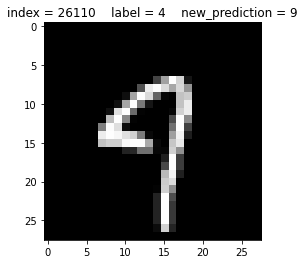

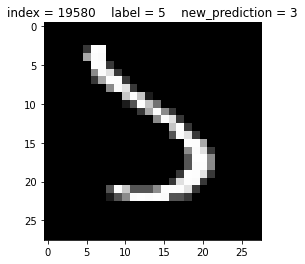

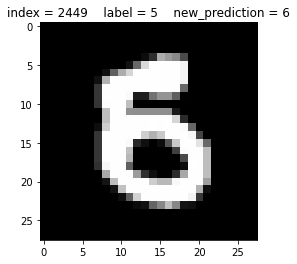

In [ ]:
# checking for labeled contaminated data in original data

original_data = np.array(original_train_df)

original_xdata = original_data[ :  , 1: ]
original_tdata = original_data[ :  , [0]]

check_data_list = np.array([original_xdata[check_index] for check_index in ori_cont_idx_list])
check_data_label_list = np.array([original_tdata[check_index] for check_index in ori_cont_idx_list]).flatten()

print("len(contaminated_data) = ", len(ori_cont_idx_list))
print("type(check_data_list) = ", type(check_data_list))
print("len(check_data_list) = ", len(check_data_list))
print()

print("check_data_list sample = ", check_data_list[:3])
print()

real_review_prediction_list = model.predict(check_data_list.reshape(-1, 28, 28, 1))
logical_review_prediction_list = np.argmax(real_review_prediction_list, axis=1)

print("type(logical_review_prediction_list) = ", type(logical_review_prediction_list))
print("len(logical_review_prediction_list) = ", len(logical_review_prediction_list))
print("logical_review_prediction_list sample = ", logical_review_prediction_list[:5])
print()

new_prediction_list = [[ori_cont_idx_list[idx], check_data_label_list[idx], val] for idx, val in enumerate(logical_review_prediction_list)]

print("new_prediction_list sample = ", new_prediction_list[:5])
print()

for cont_data_index in range(len(new_prediction_list)):

    original_data_index = new_prediction_list[cont_data_index][0]
    original_data_label = new_prediction_list[cont_data_index][1]
    original_data_new_prediction = new_prediction_list[cont_data_index][2]

    img = original_xdata[original_data_index].reshape(28, 28)

    title = 'index = ' + str(original_data_index) + '    ' + 'label = ' + str(original_data_label) + '    ' + 'new_prediction = ' + str(original_data_new_prediction)

    plt.title(title)
    plt.imshow(img, cmap='gray')
    plt.show()

## File Generation

- new version of 'digit_train.csv'
- new version of 'digit_submission.csv'

In [ ]:
new_original_train_df = original_train_df.copy()

print('type(new_original_train_df) = ', type(new_original_train_df))
print('before droping new_original_train_df.shape = ', new_original_train_df.shape)
print()

new_original_train_df.drop(new_original_train_df.index[ori_cont_idx_list], inplace=True)

print('after droping new_original_train_df.shape = ', new_original_train_df.shape)

new_original_train_df.to_csv('digit_train_v2.csv', index=False)

type(new_original_train_df) =  <class 'pandas.core.frame.DataFrame'>
before droping new_original_train_df.shape =  (41880, 785)

after droping new_original_train_df.shape =  (41877, 785)


In [ ]:
print('current directory : ', os.getcwd())
print()

os.chdir(colab_default_dir)
os.chdir('./digit_recognizer_submission/')

print('moved directory : ', os.getcwd())

predicted_num = model.predict(test_data.reshape(-1, 28, 28, 1))

result = np.argmax(predicted_num, axis=1)

model_submission = get_dataframe(result)

model_submission.to_csv('digit_submission.csv', index=False)

current directory :  /content/gdrive/My Drive/Colab Notebooks/my_own_program/AI program/data/digit_recognizer_data

moved directory :  /content/gdrive/My Drive/Colab Notebooks/my_own_program/AI program/digit_recognizer_submission


## Kaggle Submit

In [ ]:
submit_dir = '/content/gdrive/My Drive/Colab Notebooks/my_own_program/AI program/digit_recognizer_submission'

print("current directory : ", os.getcwd())

if os.getcwd() != submit_dir:
    os.chdir(submit_dir)

current directory :  /content/gdrive/My Drive/Colab Notebooks/my_own_program/AI program/digit_recognizer_submission


In [ ]:
# checking presence of kaggle.json in submit directory

!ls -1ha kaggle.json

kaggle.json


In [ ]:
# upload kaggle.json

'''
from google.colab import files
files.upload()
'''

'\nfrom google.colab import files\nfiles.upload()\n'

In [ ]:

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json
# 본인이 참가한 모든 대회 보기 
!kaggle competitions list


ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes        264           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes        147           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        352           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2381            True  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      17775            True  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       4640           False  
connectx

In [ ]:
!kaggle competitions submit -c digit-recognizer -f digit_submission.csv -m "accuracy = 99.50% (test)"

100% 208k/208k [00:02<00:00, 93.8kB/s]
Successfully submitted to Digit Recognizer

## Github Upload

In [4]:
github_local_repo = '/content/gdrive/My Drive/Colab Notebooks/my_own_program/'

os.chdir(github_local_repo)

os.getcwd()

'/content/gdrive/My Drive/Colab Notebooks/my_own_program'

In [5]:
!git config --global user.email "leeyeoreum01@gmail.com"
!git config --global user.name "leeyeoreum02"

In [ ]:
!git pull origin master

In [ ]:
!git add .

In [ ]:
!git status

In [ ]:
!git commit -m "10/11 update directory variable"

[master 5bd13c3] 10/11 update directory variable
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite AI program/digit_recognizer(tf_2.x).ipynb (95%)


In [ ]:
!git push origin master

Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 32.39 KiB | 2.94 MiB/s, done.
Total 4 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/leeyeoreum02/my_own_program.git
   dbecd6f..5bd13c3  master -> master
